In [1]:
"""Pairs trading is defined as a type of statistical arbitrage strategy where two historically correlated securities are traded against each other. 
   If they deviate from their historical relationship, 
   a trader will take positions in both securities to profit from their convergence back to the historical norm."""

'Pairs trading is defined as a type of statistical arbitrage strategy where two historically correlated securities are traded against each other. \n   If they deviate from their historical relationship, \n   a trader will take positions in both securities to profit from their convergence back to the historical norm.'

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

## Importing Data

In [3]:
Dow_30_df = pd.read_html("https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average")[1]
Dow_30_df

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,2.41%
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,3.02%
2,Amgen,NASDAQ,AMGN,Biopharmaceutical,2020-08-31,NaN,5.48%
3,Apple,NASDAQ,AAPL,Information technology,2015-03-19,NaN,2.84%
4,Boeing,NYSE,BA,Aerospace and defense,1987-03-12,NaN,3.36%
5,Caterpillar,NYSE,CAT,Construction and mining,1991-05-06,NaN,4.52%
6,Chevron,NYSE,CVX,Petroleum industry,2008-02-19,Also 1930-07-18 to 1999-11-01,3.50%
7,Cisco,NASDAQ,CSCO,Information technology,2009-06-08,NaN,0.96%
8,Coca-Cola,NYSE,KO,Drink industry,1987-03-12,Also 1932-05-26 to 1935-11-20,1.22%
9,Disney,NYSE,DIS,Broadcasting and entertainment,1991-05-06,NaN,1.89%


In [4]:
symbols = Dow_30_df["Symbol"].tolist()

In [5]:
from datetime import date
start_date = "2023-01-01"
end_date = date.today()

In [6]:
data = yf.download(
    symbols, 
    start=start_date, 
    end=end_date
)['Adj Close']

[*********************100%***********************]  30 of 30 completed


In [7]:
data

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,124.538666,256.938477,145.571487,195.389999,235.297379,134.779999,46.850143,170.792877,88.970001,49.720623,...,109.640106,238.460144,118.023865,148.750427,185.082138,514.686523,206.194107,38.172630,36.154373,141.967941
2023-01-04,125.823189,259.629150,148.955490,203.639999,237.740189,139.589996,46.840294,168.976883,91.980003,50.977280,...,110.567421,228.029129,120.468826,149.398132,185.190948,500.654297,211.384018,39.133610,36.446022,142.126114
2023-01-05,124.488876,262.054626,145.390961,204.990005,236.676376,136.339996,46.180294,172.019928,91.919998,51.542286,...,112.106369,221.270844,119.882439,147.543304,185.507462,486.225098,209.892654,39.675941,34.210068,141.641693
2023-01-06,129.069321,270.244507,149.104416,213.000000,245.127701,140.509995,47.598801,173.315659,93.919998,53.597744,...,113.290169,223.878601,123.768517,151.056702,191.758621,486.264832,216.494370,40.142155,35.590527,145.111801
2023-01-09,129.597061,265.255951,149.332794,208.570007,242.921295,147.100006,47.854923,171.961014,94.769997,53.851017,...,108.890366,226.058380,124.086571,149.211685,187.060364,486.324371,217.339478,39.980766,35.337765,143.302582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-08,179.557526,260.799988,165.869995,238.039993,282.890015,211.580002,53.060001,159.649994,88.129997,55.009998,...,106.410004,326.049988,109.690002,157.089996,167.880005,505.859985,238.840866,32.570000,29.530001,160.080917
2023-08-09,177.949707,259.320007,163.820007,237.860001,284.529999,205.860001,52.990002,159.860001,87.489998,55.540001,...,106.099998,322.230011,109.690002,156.889999,167.289993,502.109985,239.309998,32.709999,29.260000,160.339996
2023-08-10,177.729996,262.059998,163.539993,238.259995,283.820007,208.250000,53.369999,160.830002,91.760002,55.980000,...,105.570000,322.929993,109.029999,156.110001,166.940002,503.480011,240.160004,33.020000,29.230000,160.259995


## Understanding and Building the Main Function

In [9]:
# To understand the code below, we shall take run this.
n = data.shape[1]
keys = data.keys()
for i in range(n):
    for j in range(i+1, n):
        S1 = data[keys[i]] 
        S2 = data[keys[j]]
        print(S1)
        print(S2)

Date
2023-01-03    124.538666
2023-01-04    125.823189
2023-01-05    124.488876
2023-01-06    129.069321
2023-01-09    129.597061
                 ...    
2023-08-08    179.557526
2023-08-09    177.949707
2023-08-10    177.729996
2023-08-11    177.789993
2023-08-14    179.460007
Name: AAPL, Length: 154, dtype: float64
Date
2023-01-03    256.938477
2023-01-04    259.629150
2023-01-05    262.054626
2023-01-06    270.244507
2023-01-09    265.255951
                 ...    
2023-08-08    260.799988
2023-08-09    259.320007
2023-08-10    262.059998
2023-08-11    262.510010
2023-08-14    260.970001
Name: AMGN, Length: 154, dtype: float64
Date
2023-01-03    124.538666
2023-01-04    125.823189
2023-01-05    124.488876
2023-01-06    129.069321
2023-01-09    129.597061
                 ...    
2023-08-08    179.557526
2023-08-09    177.949707
2023-08-10    177.729996
2023-08-11    177.789993
2023-08-14    179.460007
Name: AAPL, Length: 154, dtype: float64
Date
2023-01-03    145.571487
2023-01-04

In [10]:
n = data.shape[1]
for i in range(n):
    for j in range(i+1, n):
        S1 = data[keys[i]] 
        S2 = data[keys[j]]
        result = coint(S1, S2)
        print(result)
# Our results gives us a tuple, with 3 elements (columns). Column 1 = t-statistic, Column 2 = p-value, Column 3 = An array with critical values.

(-0.9461747508445938, 0.9125893717792328, array([-3.96945327, -3.37635676, -3.07228646]))
(-1.5582881451522619, 0.738169817409069, array([-3.96945327, -3.37635676, -3.07228646]))
(-1.7648751321530942, 0.6466212443317381, array([-3.96945327, -3.37635676, -3.07228646]))
(-2.4677986519038533, 0.2934524204300138, array([-3.96945327, -3.37635676, -3.07228646]))
(-3.575737692083573, 0.026246423056421393, array([-3.96945327, -3.37635676, -3.07228646]))
(-2.1263724460799045, 0.4625915277914345, array([-3.96945327, -3.37635676, -3.07228646]))
(-2.3708411007743004, 0.33878670813618883, array([-3.96945327, -3.37635676, -3.07228646]))
(-4.018842773716637, 0.006749277693547076, array([-3.96945327, -3.37635676, -3.07228646]))
(-2.9871809134134377, 0.11328411012842904, array([-3.96945327, -3.37635676, -3.07228646]))
(-2.1325078710494916, 0.45939072095303723, array([-3.96945327, -3.37635676, -3.07228646]))
(-2.644124757339411, 0.22031479159666384, array([-3.96945327, -3.37635676, -3.07228646]))
(-2.32

In [11]:
print(len(result)) # For tuples, len() gives the number of elements in the tuple, which in this scenario is 3. 

3


In [12]:
n = data.shape[1]
score_matrix = np.zeros((n, n))
pvalue_matrix = np.ones((n, n))
for i in range(n):
    for j in range(i+1, n):
        S1 = data[keys[i]] 
        S2 = data[keys[j]]
        result = coint(S1, S2)
        score = result[0] 
        pvalue = result[1] 
        score_matrix = score
        pvalue_matrix = pvalue
        print(pvalue_matrix)

0.9125893717792328
0.738169817409069
0.6466212443317381
0.2934524204300138
0.026246423056421393
0.4625915277914345
0.33878670813618883
0.006749277693547076
0.11328411012842904
0.45939072095303723
0.22031479159666384
0.3597475645769862
0.19825173272877128
0.23822646459802566
0.25394274139937145
0.4712183653050246
0.19345303745766756
0.3035343087478633
0.4858638860983417
0.396915361003503
0.00042850528144095125
0.029801030722926735
0.10994496387316643
0.4024950299309056
0.1922809454472721
0.6842625203134542
0.11538646609178199
0.08531634089069912
0.1272013196688893
0.8359751442616024
0.5935212839208793
0.44847923731605177
0.9084986999176283
0.8645077215819059
0.1721398663465315
0.7073995139762916
0.15109000119703264
0.5952142734921058
0.516069846184761
0.7952446034868623
0.7280102383302363
0.8548414225252379
0.6907946061340774
0.8317817313275333
0.8582872600085967
0.8474826051730942
0.5826464382279865
0.7795137917487645
0.9062472213717745
0.9064631248537554
0.8129230910905296
0.935338545

In [13]:
# The function below aims to identify pairs of columns (series) in the provided data that have a statistically significant long-term relationship, known as cointegration.
def find_cointegrated_pairs(data):
    n = data.shape[1] # This sets n equal to the number of columns.
    score_matrix = np.zeros((n, n)) # This uses the NumPy library to create a square matrix (or 2D array) of size n x n where all entries are initialized to 0.
    pvalue_matrix = np.ones((n, n)) # This uses the NumPy library to create a square matrix (or 2D array) of size n x n where all entries are initialized to 1.
    keys = data.keys() # keys() method is an alias to the columns attribute of the DataFrame, and this code stores the columns of the data dataframe into keys.
    pairs = [] # This creates an empty list called pairs.
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]] # Note: keys[i] provides us the name of the i-th column, while data[keys[i]] gives us the values associated with that column.
            S2 = data[keys[j]] # Same as above.
            result = coint(S1, S2) # This computes the Engle-Granger two-step cointegration test and stores it in result.
            score = result[0] # This extracts the t-statistic (the first value in the tuple) and assigns it to the variable score.
            pvalue = result[1] # This extracts the p-value (the second value in the tuple) and assigns it to the variable pvalue.
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05: # Where our null hypothesis is that the two time-series are not cointegrated.
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs # This gives out three outputs.

In [14]:
find_cointegrated_pairs(data) # This returns score_matrix, pvalue_matrix, pairs. For pairs, it has to satisfy the condition pvalue < 0.05.

(array([[ 0.        , -0.94617475, -1.55828815, -1.76487513, -2.46779865,
         -3.57573769, -2.12637245, -2.3708411 , -4.01884277, -2.98718091,
         -2.13250787, -2.64412476, -2.3278373 , -2.70369726, -2.59654088,
         -2.55838761, -2.10985189, -2.71720159, -2.4456842 , -2.08183744,
         -2.25360876, -4.76861256, -3.53031459, -3.00109702, -2.24264244,
         -2.72053269, -1.6837999 , -2.97857491, -3.11506803, -2.93224739],
        [ 0.        ,  0.        , -1.27902632, -1.8732273 , -2.15345507,
         -0.9694003 , -1.17427967, -2.77997368, -1.63153061, -2.84732653,
         -1.86985439, -2.02402334, -1.40659244, -1.58300359, -1.21158432,
         -1.66925514, -1.29318796, -1.19852308, -1.23866797, -1.8947911 ,
         -1.45095716, -0.98178781, -0.98061154, -1.35376039, -0.79514695,
         -2.2823497 , -1.06442694, -0.75751826, -0.32285597, -1.17300381],
        [ 0.        ,  0.        ,  0.        , -2.78335041, -2.95999451,
         -2.22405186, -2.34652191, -

In [15]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
scores

array([[ 0.        , -0.94617475, -1.55828815, -1.76487513, -2.46779865,
        -3.57573769, -2.12637245, -2.3708411 , -4.01884277, -2.98718091,
        -2.13250787, -2.64412476, -2.3278373 , -2.70369726, -2.59654088,
        -2.55838761, -2.10985189, -2.71720159, -2.4456842 , -2.08183744,
        -2.25360876, -4.76861256, -3.53031459, -3.00109702, -2.24264244,
        -2.72053269, -1.6837999 , -2.97857491, -3.11506803, -2.93224739],
       [ 0.        ,  0.        , -1.27902632, -1.8732273 , -2.15345507,
        -0.9694003 , -1.17427967, -2.77997368, -1.63153061, -2.84732653,
        -1.86985439, -2.02402334, -1.40659244, -1.58300359, -1.21158432,
        -1.66925514, -1.29318796, -1.19852308, -1.23866797, -1.8947911 ,
        -1.45095716, -0.98178781, -0.98061154, -1.35376039, -0.79514695,
        -2.2823497 , -1.06442694, -0.75751826, -0.32285597, -1.17300381],
       [ 0.        ,  0.        ,  0.        , -2.78335041, -2.95999451,
        -2.22405186, -2.34652191, -2.44929857, -2

## Plots

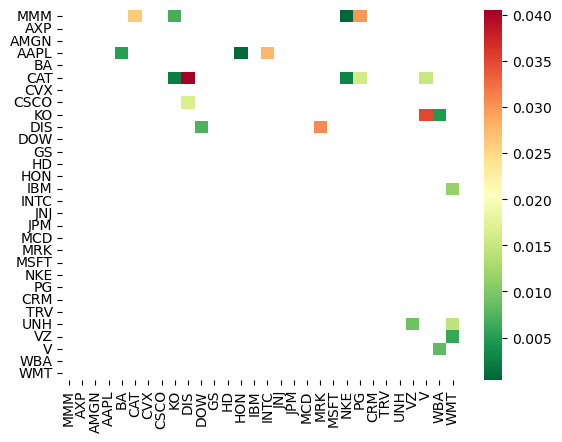

<Figure size 1000x800 with 0 Axes>

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(
    pvalues, # our data used is pvalues, which is an array. 
    xticklabels=symbols, # As our numpy array does not have any labels, we need to use xticklabels to specify what they are.
    yticklabels=symbols, 
    cmap='RdYlGn_r', # RdYlGn_r' is a diverging colormap that transitions from red to yellow to green. The _r at the end indicates that the colormap is reversed, so smaller values (closer to 0) will be green, and larger values (closer to 1) will be red.
    mask = (pvalues >= 0.05) # This is a boolean mask that specifies which cells to hide in the heatmap. In this case, any cell in the pvalues matrix that has a value greater than or equal to 0.05 will be masked (i.e., not shown).
)
plt.figure(figsize = (10,8));

In [19]:
S1 = data.UNH
S2 = data.WBA
print(S1)
print(S2)

Date
2023-01-03    514.686523
2023-01-04    500.654297
2023-01-05    486.225098
2023-01-06    486.264832
2023-01-09    486.324371
                 ...    
2023-08-08    505.859985
2023-08-09    502.109985
2023-08-10    503.480011
2023-08-11    508.010010
2023-08-14    510.929993
Name: UNH, Length: 154, dtype: float64
Date
2023-01-03    36.154373
2023-01-04    36.446022
2023-01-05    34.210068
2023-01-06    35.590527
2023-01-09    35.337765
                ...    
2023-08-08    29.530001
2023-08-09    29.260000
2023-08-10    29.230000
2023-08-11    29.350000
2023-08-14    29.070000
Name: WBA, Length: 154, dtype: float64


In [20]:
S1 = sm.add_constant(S1) # This adds the ability for the line to move up or down (i.e., have a non-zero y-intercept). This also sets S1 as our independent variable.
results = sm.OLS(S2, S1).fit() # This performs OLS regression with S2 as our dependent variable to find the best fitting model.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    WBA   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1476
Date:                Tue, 15 Aug 2023   Prob (F-statistic):              0.701
Time:                        00:33:17   Log-Likelihood:                -352.35
No. Observations:                 154   AIC:                             708.7
Df Residuals:                     152   BIC:                             714.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.3479      6.388      4.751      0.0

In [21]:
S1 = data.UNH # Reassign S1 back to the values in the UNH column in the data dataframe.
b = results.params['UNH'] 
spread = S2 - b * S1 # The spread represents the difference between the actual value of S2 and its predicted value based on the OLS regression with S1.
spread

Date
2023-01-03    33.552055
2023-01-04    33.914652
2023-01-05    31.751654
2023-01-06    33.131912
2023-01-09    32.878849
                ...    
2023-08-08    26.972310
2023-08-09    26.721270
2023-08-10    26.684343
2023-08-11    26.781439
2023-08-14    26.486675
Length: 154, dtype: float64

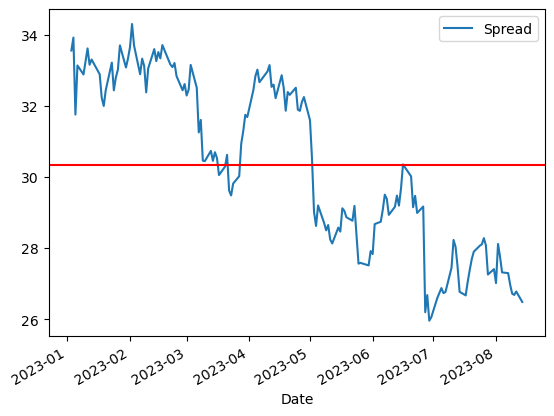

In [22]:
spread.plot() # This creates a line plot of spread.
plt.axhline(spread.mean(), color='red') # This adds a red horizontal line at the mean value of spread.
plt.legend(['Spread']);

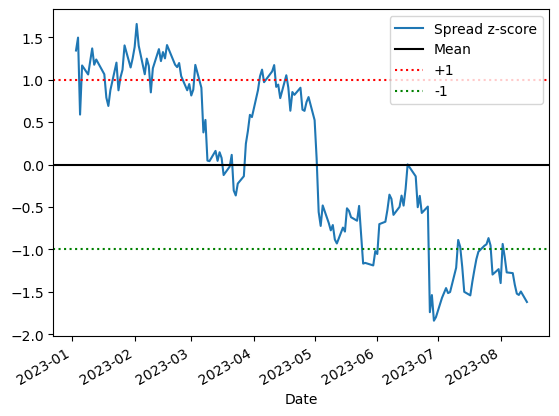

In [23]:
from scipy import stats
z_score = stats.zscore(spread) # z-score in this example has the formula: (value at x - spread.mean()) / np.std(series)

z_score.plot()
plt.axhline(z_score.mean(), color='black')
plt.axhline(1.0, color='red', linestyle=':') # 1.0 represents 1 standard deviation up and away from the mean.
plt.axhline(-1.0, color='green', linestyle=':') # -1.0 represents 1 standard deviation below and away from the mean.
plt.legend(['Spread z-score', 'Mean', '+1', '-1']); # The order of the legend entries corresponds to the order in which the lines are plotted.

In [24]:
"""The code below concatenates (or combines) the two pandas Series, 
   z_score and spread, side-by-side. The argument axis=1 indicates that the concatenation should happen along columns, 
   which means the two Series will be combined side-by-side as opposed to one below the other."""

trades = pd.concat([z_score, spread], axis=1) 
trades.columns = ["Z_score", "Spread"]                                 
trades

,Z_score,Spread
Date,,
2023-01-03,1.343661,33.552055
2023-01-04,1.495717,33.914652
2023-01-05,0.588659,31.751654
2023-01-06,1.167473,33.131912
2023-01-09,1.061351,32.878849
...,...,...
2023-08-08,-1.415571,26.972310
2023-08-09,-1.520845,26.721270
2023-08-10,-1.536331,26.684343


In [25]:
# Add a long and short position at the z-score levels
trades["Decision"] = 0 # Adding a new column called Decision, with values of 0 (default of no position).
trades.loc[trades.Z_score <= -1, "Decision"] = 1 # You would take a long spread position (+1) (buy S2 and short S1) in this scenario because S2 is relatively undervalued to S1 and is below mean spread. 
trades.loc[trades.Z_score >= 1, "Decision"] = -1
trades

,Z_score,Spread,Decision
Date,,,
2023-01-03,1.343661,33.552055,-1
2023-01-04,1.495717,33.914652,-1
2023-01-05,0.588659,31.751654,0
2023-01-06,1.167473,33.131912,-1
2023-01-09,1.061351,32.878849,-1
...,...,...,...
2023-08-08,-1.415571,26.972310,1
2023-08-09,-1.520845,26.721270,1
2023-08-10,-1.536331,26.684343,1


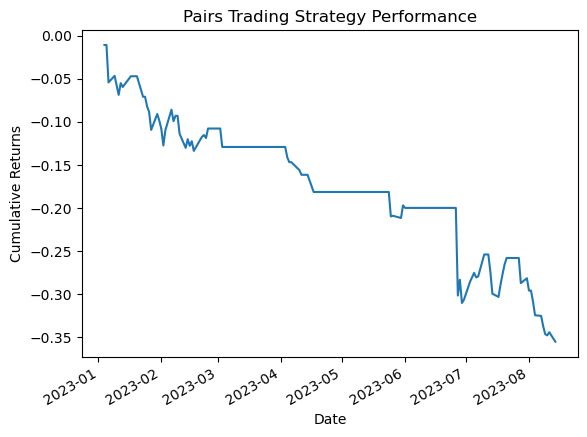

In [26]:
returns = trades.Spread.pct_change() * trades.Decision # Calculating spread change calculates the returns of the strategy.
plt.ylabel("Cumulative Returns")
plt.title('Pairs Trading Strategy Performance')
returns.cumsum().plot();
# As we can see in our plot, this is a losing strategy, which could probably be due to the non-linear relationship between S1 and S2.

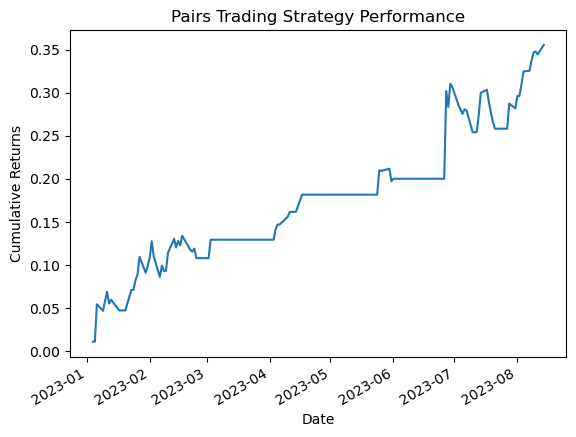

In [27]:
returns = trades.Spread.pct_change() * -(trades.Decision) 
plt.ylabel("Cumulative Returns")
plt.title('Pairs Trading Strategy Performance')
returns.cumsum().plot();
# It's funny how if we take opposing positions to the one above, we make money. Obviously, this is not a signal to trade the inverse of the above strategy.

In [ ]:
# I will be updating the code to remove the linearity assumption, and replacing it with some other functional form. For now, this will remain on GitHub.